# Experimental design

This experiments will address the effectiveness of irrigation and nitrogen fertilization to increase yield in the selected districts of Zimbabwe. For this a factorial experiment considering two factors: irrigation and nitrogen fertilization.

Nitrogen fertilization will be defined as a percentage of the recommended rate. Then, 5 nitrogen fertilization levels will be considered:
 - No nitrogen fertilization
 - 10% of recommended (7 kg N/ha)
 - 25% of recommended (17 kg N/ha)
 - 50% of recommended (35 kg N/ha)
 - 100% of recommended (70 kg N/ha)
 - 500% of recommended (350 kg N/ha)
 - No nitrogen stress

Irrigation will be defined based on the minimum water available as a percentage of the total available water in the management soil profile. It will be defined using the DSSAT automatic irrigation feature. The automatic irrigation in DSSAT applies automatic irrigation using three parameters: depth of management soil profile, IMDEP (cm); lower threshold of the total available water (TAW), ITHRL (%); and upper threshold of TAW, ITHRU (%). In automatic irrigation mode, the amount of irrigation applied is the one needed to bring the first *IMDEP* cm of the soil profile from *ITHRL*% of TAW, to *ITHRU*% of TAW. With this definition, 6 levels are defined for the irrigation factor:
 - No irrigation (Rainfed)
 - TAW > 10%
 - TAW > 20%
 - TAW > 30%
 - TAW > 40%
 - TAW > 50% 

These levels are defined by the minimum amount of water available in the management soil profile. In this case, for example, the *TAW > 25%* level means that the management soil profile will always have over 25% of the TAW. 

## DSSAT Model run
A single season run is done using the `run_district` function. This function runs the model using 50 random ensembles. The model configuration is defined as follows:
- 10 km pixels
- AgERA5 Weather data
- iSDA Soil profile
- 10 Nitrogen applications equally spaced betwen planting and 70% of the total season lenght. This aims to make sure that most of the fertilizer is used by the crop.
- Planting date defined by pixel using the Start of Season derived from MODIS using a methodology adapted from [Van Hoolst et. al. (2016)](https://www.tandfonline.com/doi/abs/10.1080/01431161.2015.1126378). The layer was created using [This gee notebook](https://github.com/daquinterop/gee_notebooks/blob/main/Phenology_maps_zimbabwe.ipynb).
- Selected cultivars at the district level. The selection was made in a previous work. The selected cultivars are all cultivars (up to 5) that show prediction skill when compared to the baseline prediction scenario. The baseline prediction scenario is the average yield of a reference period. A detailed report is found in [this document](https://docs.google.com/document/d/1sIRNoXGEWCA0uTTTyk0Qp0F6_eksDe_B_B-5FAsTQzA/edit?tab=t.0#heading=h.xgx7i7y9x21n).
- Simulation start in August 10th.
- Field capacity is assumed at teh start of the simulation.

In [1]:
from dssat_run import run_district
from itertools import product

import multiprocessing
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

# Define constants and functions

In [2]:
IRRIGATION_LEVELS = {
    "Rainfed": {"IRRIG": "N"},
    "10% TAW": {"IRRIG": "A", "IMDEP": 30, "ITHRL": 10, "ITHRU": 100},
    "20% TAW": {"IRRIG": "A", "IMDEP": 30, "ITHRL": 20, "ITHRU": 100},
    "30% TAW": {"IRRIG": "A", "IMDEP": 30, "ITHRL": 30, "ITHRU": 100},
    "40% TAW": {"IRRIG": "A", "IMDEP": 30, "ITHRL": 40, "ITHRU": 100},
    "50% TAW": {"IRRIG": "A", "IMDEP": 30, "ITHRL": 50, "ITHRU": 100}
}
NITROGEN_LEVELS = {
    "No fertilizer": 0, "10% recommended": .1, "25% recommended": .25, 
    "50% recommended": .5, "100% recommended": 1.,  "500% recommended": 5., 
    "No stress": 999
}
RECOMMENDED_NRATE = 70

In [3]:
# Functions to run all treatments for a single year
def run_single_year(district, year):
    df_list = []
    for irr_level, nitro_level in product(IRRIGATION_LEVELS, NITROGEN_LEVELS):
        sim_controls = IRRIGATION_LEVELS[irr_level]
        if nitro_level == 999:
            sim_controls["NITRO"] = "N"
        df, _ = run_district(
            admin_2=district, year=year, 
            nitro_rate=NITROGEN_LEVELS[nitro_level]*RECOMMENDED_NRATE,
            sim_controls=sim_controls
        )
        df["nitrogen"] = nitro_level
        df["irrigation"] = irr_level
        df["year"] = year
        df["admin_2"] = district
        df_list.append(df)
    return pd.concat(df_list)

## Test function on a single district and year

In [4]:
# %%time
# df = run_single_year("Chivi", 2020)

In [5]:
# df.groupby(["nitrogen", "irrigation"]).apply(lambda gb: gb.HARWT.astype(int).describe())

# Run all districts and years

In [6]:
CARE_ADMIN2 = ["Buhera", 'Mutare Rural', "Zaka", "Chivi"]
CNFA_ADMIN2 = ["Binga", 'Hwange Rural', "Lupane", "Nkayi", "Tsholotsho"]
ADMIN2 = CARE_ADMIN2 + CNFA_ADMIN2

In [25]:
# # Run simulations in parallel
# def wrap_run(treatment, return_list):
#     df = run_single_year(*treatment)
#     # df = treatment
#     return_list.append(df)

# all_simulations = list(product(ADMIN2, list(range(2000, 2023))))

# manager = multiprocessing.Manager()
# return_list = manager.list()

# n_jobs = 32
# jobs = []
# for n, sim in tqdm(list(enumerate(all_simulations))):
#     p = multiprocessing.Process(target=wrap_run, args=(sim, return_list))
#     jobs.append(p)
#     p.start()
#     # print(sim)
#     if ((n+1) % n_jobs == 0) or (n+1 == len(all_simulations)):
#         for proc in jobs:
#             proc.join()
#             jobs = []
# results = pd.concat(return_list)

# # Comment this and uncomment up when it's the first time the notebook runs
# results = pd.read_csv("data/experiment_results.csv")

  0%|          | 0/207 [00:00<?, ?it/s]

In [27]:
#Save results
results.to_csv("data/experiment_results.csv")

In [31]:
# Drop all failed simulations
results = results.loc[results.MAT != "-99"]

# Analize results

## Exponential plateau analysis

An exponential plateau function is an appropiate estimate of the increment in yield due to fertilizer application. This function describes a nearly linear increase in yield as the fertilizer ammount is increased from very small amounts, and a diminishing increase in yield as the fertilizer ammounts increase.

Then, yield given the nitrogen fertilizer rate is given by the next function:
$$
y= y_x - (y_x-y_0)e^{-kx}
$$
where $y_x$ is the maximum attainable yield (plateau), $y_0$ is the base yield (no fertilizer), $k$ is the increase rate, and $x$ is the nitrogen fertilizer rate. Next plot shows an example where $y_x=5000$, $y_0=1000$, and $k=.01$.

Text(0, 0.5, 'Yield')

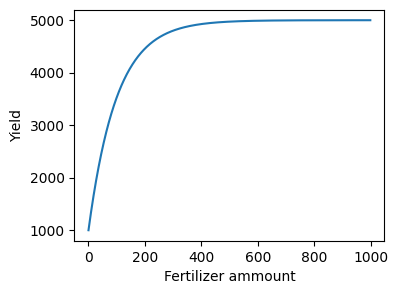

In [32]:
def exponential_plateau(nitro, rate, base, plateau):
    return plateau - (plateau - base)*np.exp(-rate*nitro)

# Example of the function
x = np.arange(0, 1000, 1)
y = exponential_plateau(x, .01, 1000, 5000)

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(x, y)
ax.set_xlabel("Fertilizer ammount")
ax.set_ylabel("Yield")

Now we can estimate the exponential plateau curve for each district. We expect that curve to be different from one district to the other, and from one season to the other. The minimum and maximum attainable yield deppend on the specific environmental conditions. Then, to analize the effect of Nitrogen fertilizer and Irrigation, one curve will be fit to each district and irrigation case for the average of a defined period. Having one curve per year does not provide much information. We can group the different seasons deppending on how dry or wet those seasons were. Therefore, each year was assigned to one of three categories: dry year, wet year, and normal year. This assignation was made based on quantiles using the average total precipitation during the growth season.

In [33]:
# tmp_df = results.loc[results.admin_2 == "Chivi"]
results_mean = results.groupby(["admin_2", "year", "nitrogen", "irrigation"]).apply(
    lambda gb: pd.Series({
        "sim_yield": gb.HARWT.astype(int).mean(),
        "rain": gb.RAIN.astype(int).mean(),
        "tirr": gb.TIRR.astype(int).mean()
        # "sim_yield": gb.loc[gb.FLO.astype(int) > 0].HARWT.astype(int).mean(),
    })
).dropna()

results_mean["nitro"] = results_mean.index.get_level_values(2).map({
    **NITROGEN_LEVELS, **{"No fertilizer": 0, "No stress":50}
})
results_mean["irr"] = results_mean.index.get_level_values(3).map(
    lambda x: IRRIGATION_LEVELS[x].get("ITHRL", 0)
) 
# Group year by Wet, normal, and dry years according to total rain quantiles
results_mean["year_type"] = results_mean.index.get_level_values(1).map(
    pd.qcut(results_mean.groupby(level="year").rain.mean(), q=3, labels=["Dry", "Normal", "Wet"])
)
results_mean = results_mean.reset_index().set_index([
    "admin_2", "year_type", "year", "nitrogen", "irrigation"
])

Considering the no Nitrogen stress scenario as the plateau might be miselading. The no nitrogen stress scenario ignores the effect of nitrogen in the crop. The yield in such scenario would be the potential ignoring the soil fertility limitations. Conversly, considering 500% of recommended scenario as the plateau is a more realistic scenario. This scenario would depict the potential yield when enough fertilizer is applied, but considering the soil fertility limitations.

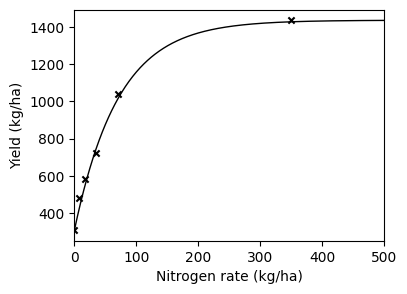

In [34]:
from scipy.optimize import lsq_linear

# Function to fit the exponential plateau. 
def fit_exponential_plateau(district, year_type, irrigation):
    tmp_df = results_mean.loc[
        (district, year_type, slice(None), slice(None), irrigation)
    ].groupby(level="nitrogen").mean()
    tmp_df = tmp_df.sort_values(by="nitro")

    tmp_df = tmp_df.loc[tmp_df.nitro < 10] # Exclude the No-nitrogen stress
    
    tmp_df["nitro"] *= RECOMMENDED_NRATE
    base = tmp_df.loc["No fertilizer", "sim_yield"]
    # plateau = tmp_df.loc["No stress", "sim_yield"]
    plateau = tmp_df.loc["500% recommended", "sim_yield"]
    tmp_df = tmp_df.loc[(tmp_df.sim_yield >= base) & (tmp_df.sim_yield <= plateau)]
    b = (
        np.log(plateau - base) -
        np.log(plateau - tmp_df.iloc[:-2].sim_yield + .0)
    ).to_numpy()
    b = np.array([b]).T
    a = tmp_df.iloc[:-2][["nitro"]].to_numpy()
    
    rate = lsq_linear(a, b.flatten()).x
    return base, plateau, rate, tmp_df

def plot_exponential_plateau(district, year_type, irrigation, ax, color="k"):
    base, plateau, rate, tmp_df = fit_exponential_plateau(district, year_type, irrigation)
    
    tmp_df.plot.scatter(
        x="nitro", y="sim_yield", ax=ax, marker="x", color=color,
        zorder=2
    )
    x = np.arange(0, 500)
    ax.plot(
        x,
        exponential_plateau(x, rate, base, plateau),
        color=color, zorder=1, linewidth=1
    )
    ax.set_xlabel("Nitrogen rate (kg/ha)")
    ax.set_ylabel("Yield (kg/ha)")
    ax.set_xlim(0, 500)
    # ax.set_xticklabels(ax.get_xticks()*RECOMMENDED_NRATE);


# Test the function to fit the exponential Plateau
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plot_exponential_plateau("Hwange Rural", "Dry", "Rainfed", ax)

Now we can generate the curves for all sites, and analyze how important is fertilizer and irrigation deppending on the site and the type of season (dry, wet, normal).

### CNFA Sites

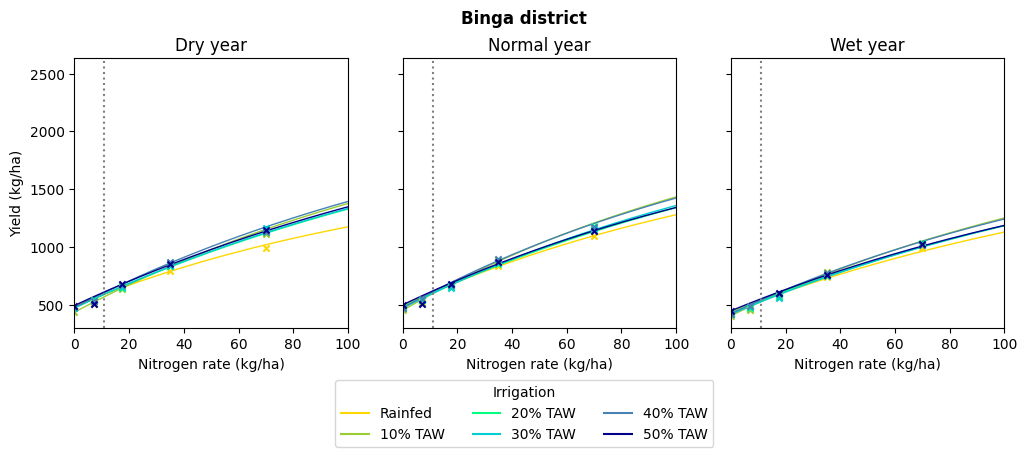

In [35]:
from matplotlib.lines import Line2D

irrigation_colors = {
    'Rainfed': "gold", '10% TAW': "yellowgreen",
    '20% TAW': "springgreen", '30% TAW': "darkturquoise",
    '40% TAW': "steelblue", '50% TAW': "darkblue"
}

def plateau_plot_district(district):
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5), sharex=True, sharey=True)
    for n, year_type in enumerate(("Dry", "Normal", "Wet")):
        ax = axes[n]
        for m, irr_type in enumerate(IRRIGATION_LEVELS):
            plot_exponential_plateau(district, year_type, irr_type, ax, irrigation_colors[irr_type])
        #     if n == 0:
        #         ax.set_title(irr_type)
        # axes[n][0].set_ylabel(f"{year_type} year\nyield(kg/ha)")
        ax.set_title(f"{year_type} year")
        ax.set_xlim(0, 100)
        # Plot what is believed to be the current scenario
        ax.axvline(11, color="gray", linestyle=":")
    fig.suptitle(f"{district} district", fontweight="bold", y=1.02)
    fig.legend(
        [Line2D([0], [0], color=irrigation_colors[ir]) for ir in irrigation_colors],
        irrigation_colors.keys(), ncols=3, loc="lower center", bbox_to_anchor=(.5, -0.25),
        title="Irrigation"
    )
    fig.show()
    
    
plateau_plot_district("Binga")

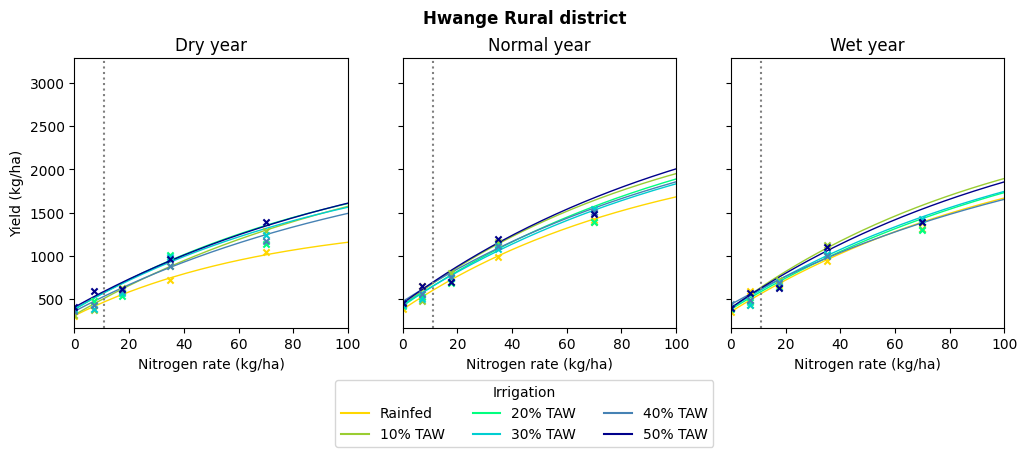

In [36]:
plateau_plot_district("Hwange Rural")

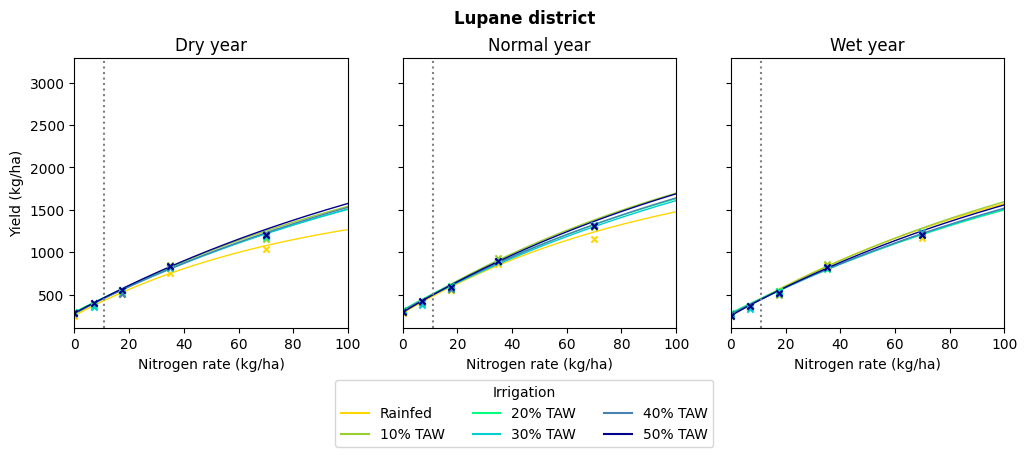

In [37]:
plateau_plot_district("Lupane")

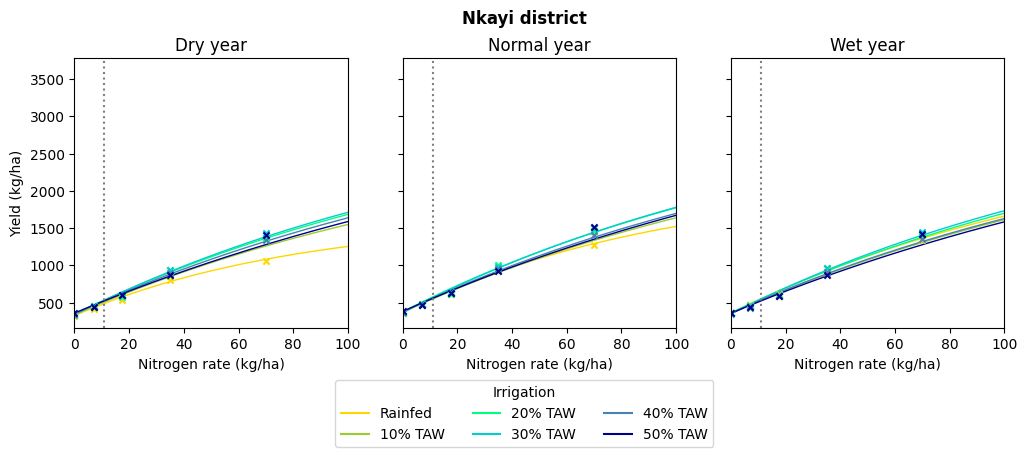

In [38]:
plateau_plot_district("Nkayi")

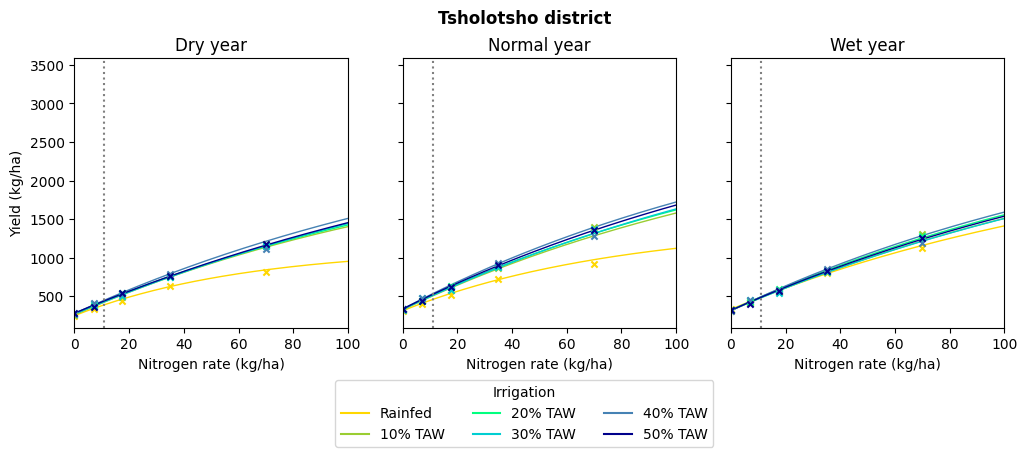

In [39]:
plateau_plot_district("Tsholotsho")

### CARE Sites

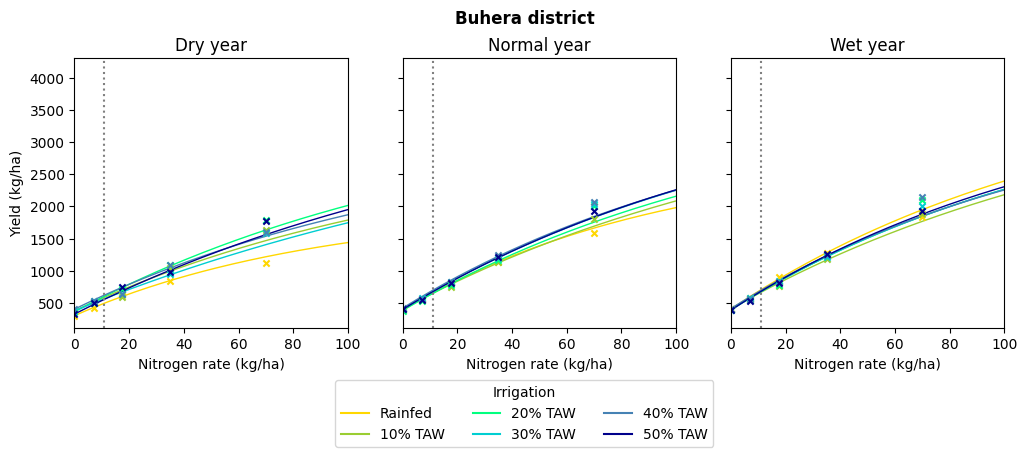

In [40]:
plateau_plot_district("Buhera")

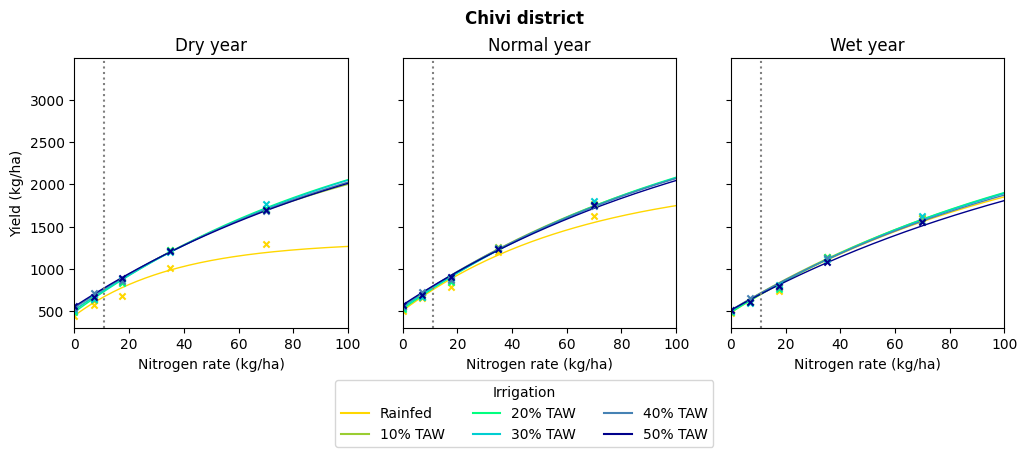

In [41]:
plateau_plot_district("Chivi")

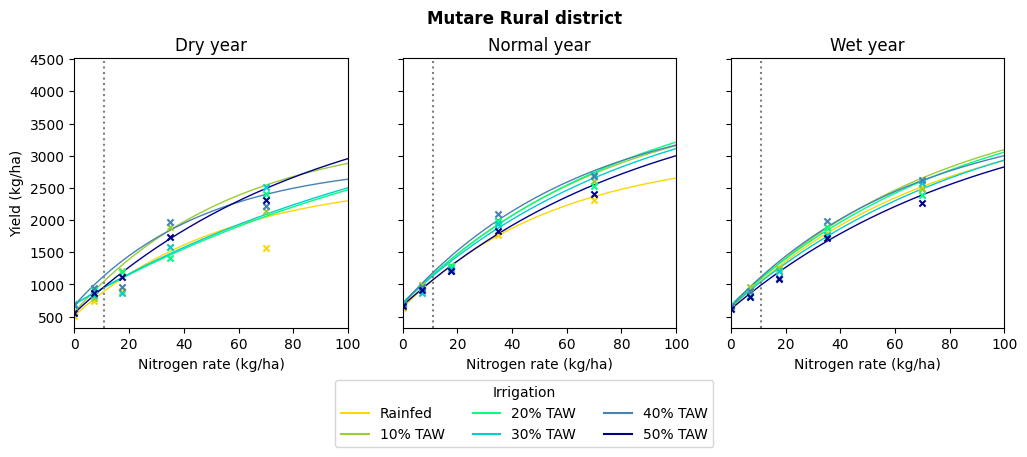

In [42]:
plateau_plot_district("Mutare Rural")

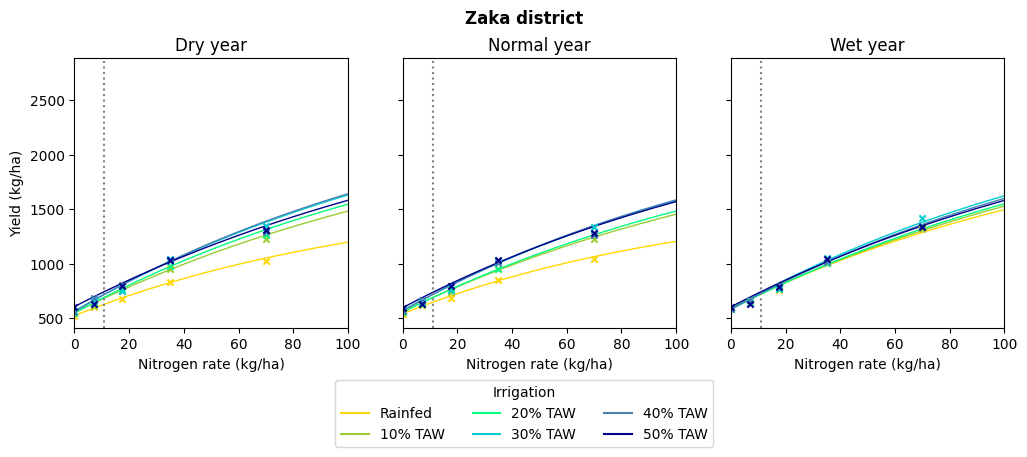

In [43]:
plateau_plot_district("Zaka")

## Current nitrogen fertilizer scenario

The objective is to evaluate the effect of irrigation when the current fertilizer scenario is considered. The current fertilizer scenario was obtained through Bayesian Calibration (Quintero et. al., 2025). It is 11 kg N/ha.

In [61]:
import matplotlib.ticker as mtick
year_colors = {"Dry": "indianred", "Normal": "gray", "Wet": "teal"}

def irrigation_efect_plot(ax, district, nitro=11, nitro_ref=11):
    # Normal year reference yield
    base, plateau, rate, tmp_df = fit_exponential_plateau(district, "Normal", "Rainfed")
    ref_yield = exponential_plateau(nitro_ref, rate, base, plateau)
    _, xmax = ax.get_xlim()
    for year_type, color in year_colors.items():
        yld_vals = []
        irr_vals = []
        for irr in IRRIGATION_LEVELS:
            base, plateau, rate, tmp_df = fit_exponential_plateau(district, year_type, irr)
            # Approximate irrigation needed for that specific nitrogen rate
            tmp_df = tmp_df.set_index("nitro")
            tmp_df.loc[float(nitro)] = [None, None, None, None]
            # Save irrigation and yield values
            yld_vals.append(exponential_plateau(nitro, rate, base, plateau))
            irr_vals.append(tmp_df.sort_index().interpolate().tirr[float(nitro)])
        xmax = max(xmax, max(irr_vals))
        yld_vals = np.array(yld_vals).flatten()
        yld_vals = 100*(yld_vals - ref_yield)/ref_yield
        ax.plot(irr_vals, yld_vals, color=color, label=year_type)
    ax.set_title(district)
    # ax.set_xticks([0, 10, 20, 30, 40, 50])
    ax.set_xlim(0, xmax)
    ax.grid(axis="y", linestyle=':')
    ax.axhline(0, color="k", linestyle=":")
    ax.set_ylabel("Change in yield (%)")
    ax.set_xlabel("Total Irrigation (mm)")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())

**Plot interpretation**
The figure below shows one example of the Chivi district. The plot shows the different irrigation amounts on the x-axis. The y-axis shows the change in yield (%). That change is relative to the expected yield in a normal year when no irrigation is used. There are three lines, each for one of the climate types of a year: dry, normal, and wet. 

The plot shows how different irrigation amounts affect yield under the current fertilizer practices. When no irrigation is applied in a dry year, there is a reduction in yield of almost 10%. When irrigation is applied that change in yield is reduced. With around 50 mm of irrigation, the yield in a dry year is almost the same as in a rainfed normal year. Then that would be the amount of water needed to dampen the effect of a dry year on yield. It is also shown that wet years also cause a reduction in yield. Compared to dry years, irrigation does not make a difference in wet years.

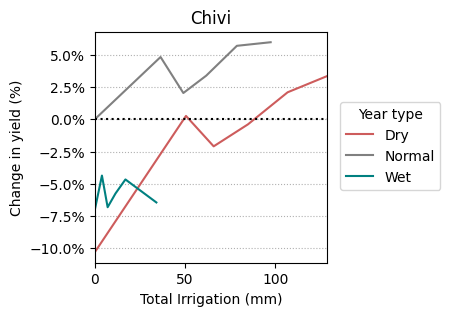

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
irrigation_efect_plot(ax, "Chivi", 11)

fig.legend(
    [Line2D([0], [0], color=year_colors[ir]) for ir in year_colors],
    year_colors.keys(), ncols=1, loc="center right", bbox_to_anchor=(1.3, .5),
    title="Year type"
)

### CNFA Sites

Text(0.5, 0.98, 'Change in yield relative to a rainfed normal year')

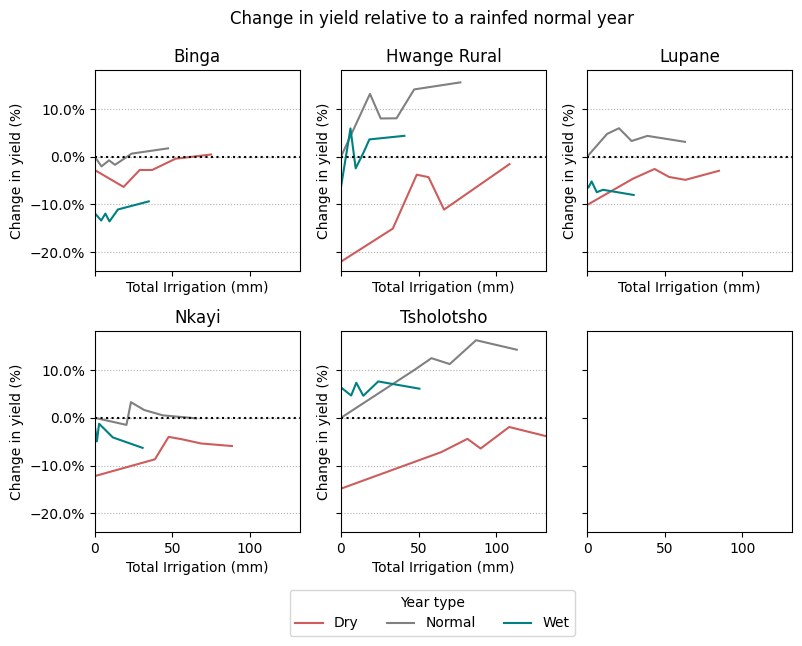

In [63]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
axes = axes.flatten()

for n, district in enumerate(CNFA_ADMIN2):
    ax = axes[n]
    irrigation_efect_plot(ax, district, 11)

fig.legend(
        [Line2D([0], [0], color=year_colors[ir]) for ir in year_colors],
        year_colors.keys(), ncols=3, loc="lower center", bbox_to_anchor=(.5, -0.075),
        title="Year type"
    )

plt.subplots_adjust(hspace=.3)
fig.suptitle("Change in yield relative to a rainfed normal year")

### CARE Sites

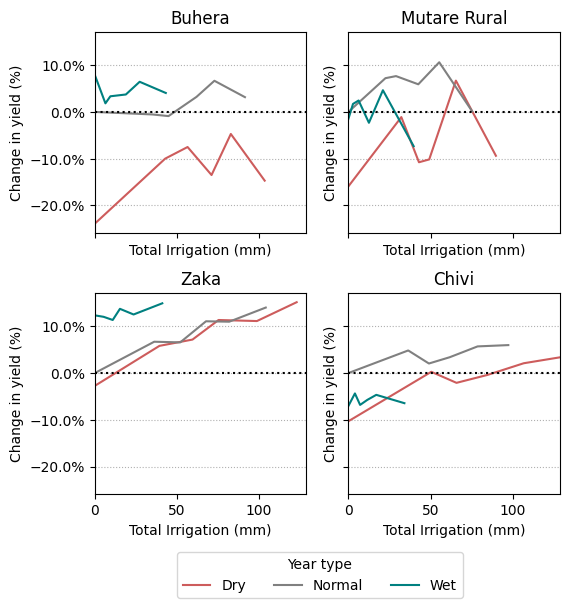

In [64]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
axes = axes.flatten()

for n, district in enumerate(CARE_ADMIN2):
    ax = axes[n]
    irrigation_efect_plot(ax, district, 11)

fig.legend(
        [Line2D([0], [0], color=year_colors[ir]) for ir in year_colors],
        year_colors.keys(), ncols=3, loc="lower center", bbox_to_anchor=(.5, -0.075),
        title="Year type"
    )

plt.subplots_adjust(hspace=.3)

## Current Fertilizer + Legume fixation

This evaluates the effect of irrigation in a maize-bean intercropping scenario. In that case, the nitrogen fertilizer would be the actual rate, plus the entra nitrogen available to the main crop resulting from the legume fixation. That amount of fertilizer is known as Fertilizer Replacement Value (FRV) and it was estimated as 36 kg N/ha for an experiment conducted in a maize-legume system in Zimbabwe [(Jeranyama et al., 2000)](https://acsess.onlinelibrary.wiley.com/doi/abs/10.2134/agronj2000.922239x).

### CNFA Sites

Text(0.5, 0.98, 'Change in yield relative to a rainfed normal year\nwith no intercropping')

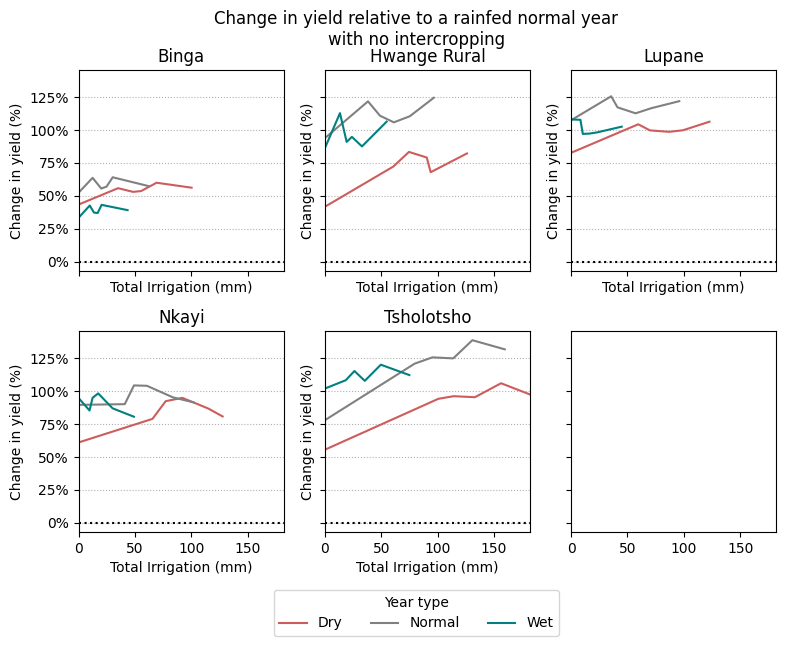

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True)
axes = axes.flatten()

for n, district in enumerate(CNFA_ADMIN2):
    ax = axes[n]
    irrigation_efect_plot(ax, district, 11+36)

fig.legend(
        [Line2D([0], [0], color=year_colors[ir]) for ir in year_colors],
        year_colors.keys(), ncols=3, loc="lower center", bbox_to_anchor=(.5, -0.075),
        title="Year type"
    )

plt.subplots_adjust(hspace=.3)
fig.suptitle("Change in yield relative to a rainfed normal year\nwith no intercropping")

## CARE Sites

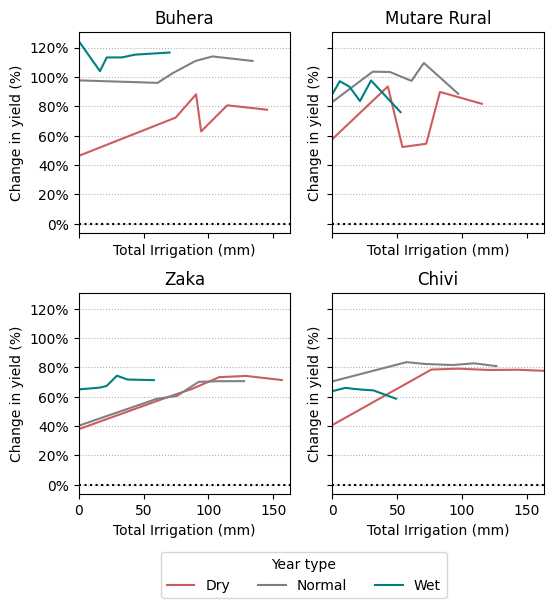

In [67]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharex=True, sharey=True)
axes = axes.flatten()

for n, district in enumerate(CARE_ADMIN2):
    ax = axes[n]
    irrigation_efect_plot(ax, district, 11+33)

fig.legend(
        [Line2D([0], [0], color=year_colors[ir]) for ir in year_colors],
        year_colors.keys(), ncols=3, loc="lower center", bbox_to_anchor=(.5, -0.075),
        title="Year type"
    )

plt.subplots_adjust(hspace=.3)